# Predicting Sentiment in Tweets Involving the Dallas Mavericks

#### Brian Johns, May 2023

## Notebook #4: Final Summary & Analysis

Through the first 3 notebooks, I have cleaned, analyzed and modelled the data in order to predict the `Sentiment` of tweets with the 'Dallas Mavericks' as the key subject.  After attempting multiple different solvers for Logistic Regression models, as well as Naive Bayes models, it was found that a **Logistic Regression model, using a lbfgs solver and standard scaling for the data** was the highest performing model with an accuracy score of 84.17%.

Here, I will apply this validated model to the test data and analyze the final results of the model.  I will then analyze the final result and suggest some real-world use-cases for the model, as well as outline some areas for future learning.

In this notebook, I will do the following:

1. [Application of Model on Test Data](#test)
2. [Final Model Analysis](#finalmodel)
3. [Future Learning & Next Steps](#nextsteps)

In [22]:
# Other libraries were used for this project, but these are the only ones needed for final analysis of the test data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score, RocCurveDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

<a id = 'test'></a>

## 1. Application of Model on Test Data

I will use the same functions that I used to evaluate the models in the training process.

Here I will be able to use the 'plot_coefs' function more specifically to help identify what features had the biggest predictive impact on the testing data.  This will help identify some key areas to target for final analysis of the model.

In [23]:
def model_eval(model, X_train, X_test, y_train, y_test):    
    # Evaluate the Model
    predictions = model.predict(X_test)
    print(f'Training Score: {round(model.score(X_train, y_train)*100, 4)}%')
    print(f'Testing Score: {round(model.score(X_test, y_test)*100, 4)}%')
    print(classification_report(y_test, predictions))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    plt.xticks(rotation = 30)

In [24]:
# Helper Function that will plot out the Top 20 features, likely to be tokens
def plot_coefs(model, X):
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "feature": X.columns})
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # largest negative coefficients - May not align with Positive/Negative Sentiment based on Model
    coef_df.tail(20).set_index("feature").plot(kind="bar", rot=45, ax=axs[0], color="red")
    axs[0].set_title("Negative indicators")
 
    
    # largest positive coefficients - May not align with Positive/Negative Sentiment based on Model
    coef_df.head(20).set_index("feature").plot(kind="bar", rot=45, ax=axs[1], color="blue")
    axs[1].set_title("Positive indicators")
    
    sns.despine()
    plt.tight_layout()
    plt.show()

In [26]:
# Loading the same data that was used to train the models
X_train_full = pd.read_pickle('mavs_X_train.pickle')
y_train_full = pd.read_pickle('mavs_y_train.pickle')
X_test = pd.read_pickle('mavs_X_test.pickle')
y_test = pd.read_pickle('mavs_y_test.pickle')

In [27]:
# Applying SMOTE to the training data in preparation for applying the model to the test data
X_train_sm, y_train_sm = SMOTE(random_state = 77).fit_resample(X_train_full, y_train_full)

In [28]:
# Standard Scaling outperformed MinMax and No Scaling in the training process
ss = StandardScaler().fit(X_train_sm)
X_train_ss = ss.transform(X_train_sm)
X_test_ss = ss.transform(X_test)

In [29]:
# The lbfgs solver was the highest performing solver in the training process
logreg_ss = LogisticRegression(multi_class = 'multinomial',
                               solver = 'lbfgs')
logreg_ss.fit(X_train_ss, y_train_sm)

/Users/brianjohns/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

Training Score: 84.5363%
Testing Score: 83.4512%
              precision    recall  f1-score   support

    Negative       0.75      0.67      0.71     10014
     Neutral       0.82      0.95      0.88     20735
    Positive       0.90      0.80      0.85     21835

    accuracy                           0.83     52584
   macro avg       0.82      0.81      0.81     52584
weighted avg       0.84      0.83      0.83     52584



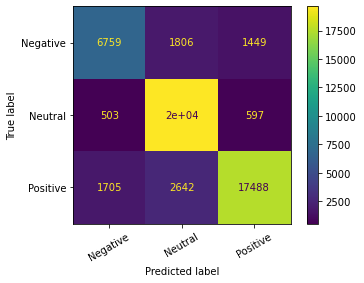

In [30]:
# Evaluating the actual test data on the model
model_eval(logreg_ss, X_train_ss, X_test_ss, y_train_sm, y_test)

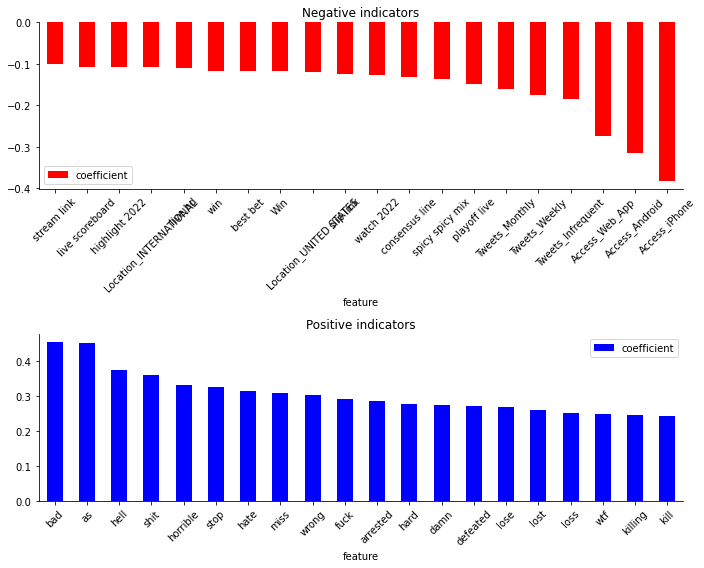

In [31]:
# Most impactful features for the model
plot_coefs(logreg_ss, X_train_sm)

Interestingly, compared to the validation scores when fitting the model, the score on the testing data actually **improved** by 0.2% to an overall accuracy of 83.45%.

Compared to the validation scores, it would appear that the model performed slightly better on precision for positive and negative `Sentiment` by 1% each.  This is good to see considering that the general weakness of the model seems to be separating predictions between positive and negative (as oppose to between neutral and the others).  However, it does seem like the model's weakness is predicting Negative `Sentiment` as a result of the imbalance in the data.

Reading coefficients for multi-class models can be challenging, but it would appear here that the coefficients with positive values coincide with Negative `Sentiment` and the coefficients with negative values coincide with Neutral `Sentiment`

In [32]:
label_binarizer = LabelBinarizer().fit(y_train_sm)
y_ohe_test = label_binarizer.transform(y_test)
y_score = logreg_ss.predict_proba(X_test_ss)

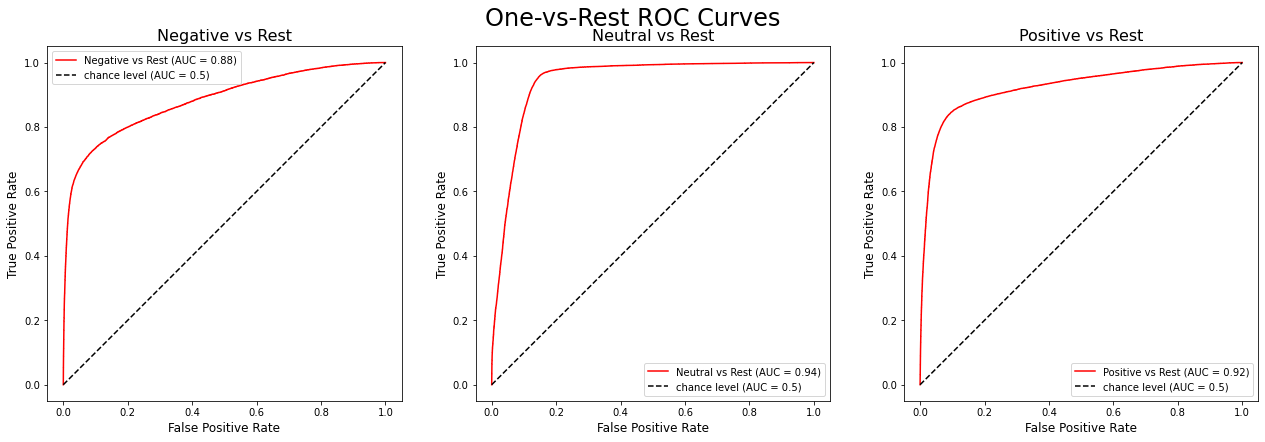

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('One-vs-Rest ROC Curves', fontsize = 24)

for n, sentiment in enumerate(label_binarizer.classes_):
    ax = axes[n]
    
    class_id = np.flatnonzero(label_binarizer.classes_ == sentiment)[0]
    
    RocCurveDisplay.from_predictions(
        y_ohe_test[:, class_id],
        y_score[:, class_id],
        name=f"{sentiment} vs Rest",
        color="red",
        ax=ax)
    
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate", fontsize = 12)
    ax.set_ylabel("True Positive Rate", fontsize = 12)
    ax.set_title(f"{sentiment} vs Rest", fontsize = 16)
    ax.legend()

plt.tight_layout()
plt.show()

In analyzing the AUC values, there was no change in the values in distinguishing any class from the others.

<a id = 'finalmodel'></a>

## 2. Final Model Analysis

In the end, this model is best at identifying Neutral `Sentiment` and generally weak at predicting Negative `Sentiment` in general.

Using this model in the real world, it could be best used to identify tweets with Positive `Sentiment` and targeting those users of those tweets with future promotions or advertisements.  Potentially, those that are sending more positive tweets about the Dallas Mavericks would be those that would be more amendable to buying Mavericks gear or tickets.

For a professional sports team, this model could give a sense of what the fans think of the team after transactions or staffing changes.  While a fan's opinion may not be a determining factor in the direction of the franchise, having a sense of the fans reaction can help better craft a message to the fans in order to maintain support during times of change.

As well, by using this model to identify positive tweets, and further identifying where those positive tweets are coming from, perhaps the Mavericks could identify specific communities to target campaigns and ticket sales.  While it would be obvious to see positive tweets come from Dallas or Serbia (the home country of star player Luka Doncic), identifying other areas could help unlock markets that the Mavericks could reach out to.

While this model is not as strong in identifying tweets with a negative `Sentiment`, it could still be used to identify big areas of concern for the franchise within its fan base.  While some events (losing games, trading a fan favorite player) would spark an emotional response from the fan base resulting in several negative tweets, other concerns may not get the same volume of tweets (perhaps customer service or concessions at a game).  Using this model as a first glance of fan's issues would be a good start in providing a better fan experience for the Dallas Mavericks.

<a id = 'nextsteps'></a>

## 3. Future Learnings & Next Steps

This project gave me the opportunity to use NLP on a classification model using Logistic Regression and Naive Bayes models.  However, given the size of the data, expecially after conducting NLP on the dataset, it was clear that doing extensive modeling on my local computer was going to be a challenge.

Therefore, the next steps for this project would be to leverage big data tools from AWS.  This would allow me to store the data and utilize the tools there in order to conduct faster, more robust modeling.

With those tools, I could then optimize the Logistic Regression model to a greater degree, but then expand to other forms of modeling such as SVC models and, eventually, Neural Networks.

Expanding this project to include this could provide a more accurate model that could help the Dallas Mavericks, or any other sports franchise, to service their fans to an even greater degree.